# Exploring CMH Parking Violations

## Imports

* pandas

In [92]:
#%matplotlib inline
#import numpy as np

import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import datetime

### Loading data

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,) This dataset covers years 2013 through 2018.

In [93]:
parking = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz", compression = 'gzip', low_memory = False)

In [94]:
pd.set_option('display.max_columns', None)
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 98 columns):
nix dt        745821 non-null int64
hrg offcr     27951 non-null object
dispo         745821 non-null int64
badge         733375 non-null object
susp til      745821 non-null int64
mail1 dt      745821 non-null int64
iss dt        745821 non-null int64
ent due       745821 non-null object
viol          745821 non-null int64
ipp no        745821 non-null int64
mail2 dt      745821 non-null int64
conf dt2      745821 non-null int64
fine          745821 non-null object
coll dt       745821 non-null int64
pen4          745821 non-null object
corro         745821 non-null int64
last seiz     745821 non-null int64
hear proc     745821 non-null int64
dis dt        745821 non-null int64
mail1 pdt     745821 non-null int64
bootbl ct     745821 non-null int64
ticket        745821 non-null object
entity        745821 non-null int64
plea          0 non-null float64
multno        745821 no

In [95]:
dictionary = pd.read_json("https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
dictionary.head(98)

,type,name,description
0,integer,ENTITY,Unique system-generated number to identify license plate-based accounts
1,integer,TERMDT,"If a license plate was on a fleet and terminated, this would record the date on which the plate was terminated from the fleet. Julian date format."
2,integer,MULTNO,"If a license plate was on a fleet, that fleet is identified with this number"
3,string,ENT DUE,Total amount due on the entity
4,string,ENT OVP,Overpaid amount on the entity
5,integer,CONF DT,Date on which the BMV/Registry returned registered owner name and address information
6,integer,HOLD CT,Total number of tickets on the entity on registration hold
7,integer,LAST SEIZ,Date on which the vehicle was last seized
8,string,SEIZ STAT,Indicates if the vehicle is currently seized
9,integer,SEIZ DT,Date on which the vehicle was released on the last seizure record


In [96]:
# work with a smaller data set
parking_slim = parking[['ticket', 'entity',  'iss dt', 'multno', 'hold ct', 'due', 'fine', 'make', 'iss time', 'time2', 'ticket', 'badge', 'pay amt', 'pay meth', 'plea', 'open ct']].copy()
parking_slim['issue_date'] = parking['iss dt'].map(lambda dtStr: datetime.datetime.strptime(str(dtStr), '%Y%j'))
parking_slim['year'] = parking_slim['issue_date'].map(lambda dt: dt.year)

In [97]:

# re.sub(r'', r'', re.sub(r'\(?\$?([.0-9]+)\)?', r'\1', amtStr)
#parking_slim['amt'] = parking_slim['pay amt'].map(lambda amtStr: str(amtStr).translate(?))
 
import string
trans_dict ={ord('$'): None, ord('('): None, ord(')'): None, ord(","): None} 
parking_slim['amt'] = parking_slim['pay amt'].str.translate(trans_dict).astype(float)
parking_slim['amt']

0         30.0
1         90.0
2         65.0
3         45.0
4         70.0
          ... 
745816    80.0
745817    40.0
745818    85.0
745819    40.0
745820    40.0
Name: amt, Length: 745821, dtype: float64

In [98]:
parking_slim.info()
parking_slim.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 19 columns):
ticket        745821 non-null object
entity        745821 non-null int64
iss dt        745821 non-null int64
multno        745821 non-null int64
hold ct       745821 non-null int64
due           745821 non-null object
fine          745821 non-null object
make          744965 non-null object
iss time      745821 non-null int64
time2         745821 non-null int64
ticket        745821 non-null object
badge         733375 non-null object
pay amt       745821 non-null object
pay meth      745821 non-null int64
plea          0 non-null float64
open ct       745821 non-null int64
issue_date    745821 non-null datetime64[ns]
year          745821 non-null int64
amt           745821 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(9), object(7)
memory usage: 108.1+ MB


,ticket,entity,iss dt,multno,hold ct,due,fine,make,iss time,time2,ticket,badge,pay amt,pay meth,plea,open ct,issue_date,year,amt
51921,5564163304,3162996,2015021,0,0,$0.00,$30.00,NISS,850,0,5564163304,9,$30.00,4,NaN,0,2015-01-21,2015,30.0
198222,5564592695,2577484,2015079,0,0,$0.00,$30.00,MERZ,1902,0,5564592695,20,$30.00,4,NaN,0,2015-03-20,2015,30.0
444767,5594756362,3306722,2013140,0,0,$0.00,$50.00,TOYT,1611,0,5594756362,679,$50.00,4,NaN,0,2013-05-20,2013,50.0
72467,5561481906,3295654,2013092,0,0,$0.00,$40.00,LEXU,1322,0,5561481906,6,$40.00,4,NaN,0,2013-04-02,2013,40.0
479411,5595457515,3396713,2014147,0,0,$80.00,$45.00,CHEV,1149,0,5595457515,NaN,$0.00,0,NaN,2,2014-05-27,2014,0.0
730125,5564937121,3484843,2015194,0,0,$0.00,$30.00,LEXU,1508,0,5564937121,9,$30.00,4,NaN,0,2015-07-13,2015,30.0
557825,5565626374,3525919,2016022,0,0,$0.00,$55.00,TOYT,1315,0,5565626374,10,$55.00,2,NaN,0,2016-01-22,2016,55.0
175164,5562318631,3347039,2013311,0,0,$0.00,$45.00,SATU,1006,0,5562318631,16,$85.00,1,NaN,0,2013-11-07,2013,85.0
160450,5566659224,3592679,2016319,0,0,$0.00,$30.00,HYUN,1808,0,5566659224,17,$45.00,4,NaN,0,2016-11-14,2016,45.0
243964,5561143762,3285745,2013031,0,0,$0.00,$25.00,LEXU,811,0,5561143762,8,$40.00,4,NaN,0,2013-01-31,2013,40.0


In [99]:
parking_slim['year'].value_counts()

2014    158001
2013    157787
2015    141000
2016    137000
2017    119000
2018    33033 
Name: year, dtype: int64

In [100]:
# who got most tickets, and how much did it cost
parking_slim[['entity', 'amt']].groupby('entity').agg(['count', 'sum']).sort_values([('amt', 'count')], ascending=False)

amt        
         count     sum
entity                
3306104   171   5965.0
3172961   149   6110.0
3118181   141   5990.0
2954098   107   3530.0
3177010   100   3315.0
...       ...      ...
3405188   1     0.0   
3405187   1     25.0  
3405184   1     0.0   
3405183   1     25.0  
99999959  1     0.0   

[433099 rows x 2 columns]

In [153]:
# get and save network graph
try:
    G = ox.load_graphml('cmh_network.graphml')
except IOError:
    print("Download and save network.")
    G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive')
    G_projected = ox.project_graph(G)
    ox.save_graphml(G_projected, filename='cmh_network.graphml')
    G = ox.load_graphml('cmh_network.graphml')

# fig, ax = ox.plot_graph(G3)

In [154]:

cmh_gdf = ox.graph_to_gdfs(G)
cmh_gdf[0]

,y,x,osmid,highway,ref,lon,lat,geometry
1835532289,4.426192e+06,330799.163558,1835532289,nan,nan,-82.9812432,39.968961,POINT (330799.164 4426191.820)
2420047873,4.421038e+06,342761.111914,2420047873,nan,nan,-82.8400022,39.9248548,POINT (342761.112 4421037.563)
2420047874,4.421061e+06,342585.897083,2420047874,nan,nan,-82.8420571,39.925029,POINT (342585.897 4421060.522)
2420047875,4.421097e+06,342597.541877,2420047875,nan,nan,-82.8419298,39.9253632,POINT (342597.542 4421097.394)
2420047880,4.421121e+06,342548.750598,2420047880,nan,nan,-82.8425063,39.9255712,POINT (342548.751 4421121.498)
...,...,...,...,...,...,...,...,...
229638117,4.430915e+06,330081.984165,229638117,nan,nan,-82.990871,40.011347,POINT (330081.984 4430915.060)
229703663,4.427031e+06,328791.348462,229703663,nan,nan,-83.0049608,39.9761094,POINT (328791.348 4427030.588)
229965808,4.416998e+06,335304.263118,229965808,nan,nan,-82.926197,39.887058,POINT (335304.263 4416997.567)
229703669,4.424518e+06,342748.468847,229703669,nan,nan,-82.84099,39.956191,POINT (342748.469 4424517.600)


In [150]:
cmh_gdf[0].x.agg(['min', 'max'])
cmh_gdf[0].y.agg(['min', 'max'])

min    4.413882e+06
max    4.446597e+06
Name: y, dtype: float64

In [157]:
cmh_gdf = ox.graph_to_gdfs(G)



cmh_n = float(cmh_gdf[0].lat.agg('max'))
cmh_s = float(cmh_gdf[0].lat.agg('min'))
cmh_e = float(cmh_gdf[0].lon.agg('max'))
cmh_w = float(cmh_gdf[0].lon.agg('min'))

print(cmh_n, cmh_s, cmh_e, cmh_w)

40.1527582 39.860829 -83.172436 -82.7721843


In [112]:

type(cmh_n)

float

In [55]:
# cmh2 = ox.gdf_from_place('Columbus, Ohio')
# type(cmh2)

geopandas.geodataframe.GeoDataFrame

In [87]:
# cmh2 = ox.gdf_from_place('Columbus, Ohio')
# # Gs = ox.plot_shape(ox.project_gdf(cmh))

# cmh_boundaries = ox.project_gdf(cmh2)
# cmh_n = cmh_boundaries.bbox_north[0]
# cmh_s = cmh_boundaries.bbox_south[0]
# cmh_e = cmh_boundaries.bbox_east[0]
# cmh_w = cmh_boundaries.bbox_west[0]
# print(cmh_n, cmh_s, cmh_e, cmh_w)

40.157272 39.8086936 -82.7713119 -83.2101797


In [103]:
parking['lat_float'] = parking['lat'] / 1000000
parking['long_float'] = parking['long'] / 1000000 * -1

In [104]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [105]:
#meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns = {'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [109]:
parking_loc = parking[['meter', 'lat_float', 'long_float', 'location']]
parking_loc = parking_loc.rename(columns = { 'meter': 'Meter'})

meters_loc = meters[['Meter', 'Lat', 'Long']]

parking_x_meters = parking_loc.merge(meters_loc, how = 'left', on = 'Meter')

pxm = parking_x_meters.copy()
pxm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745821 entries, 0 to 745820
Data columns (total 6 columns):
Meter         418804 non-null object
lat_float     745821 non-null float64
long_float    745821 non-null float64
location      745635 non-null object
Lat           412790 non-null float64
Long          412790 non-null float64
dtypes: float64(4), object(2)
memory usage: 39.8+ MB


In [158]:
#print (cmh_n, cmh_s, cmh_e, cmh_w)
fudge = 0.2
pxm['lat_combined'] = \
    pxm.apply(lambda p: p['Lat'] if (p['Lat'] >  cmh_s - fudge) & (p['Lat'] < cmh_n + fudge) \
                                    else p['lat_float'], axis=1)

pxm['long_combined'] = \
    pxm.apply(lambda p: p['Long'] if (p['Long'] >  cmh_w - fudge) & (p['Long'] < cmh_e + fudge)  \
                                    else  p['long_float'], axis=1)

In [159]:
pxm_na = pxm[['lat_combined', 'lat_float', 'Lat', 'long_combined', 'long_float', 'Long', 'location', 'Meter']]
pxm_na[['lat_combined', 'long_combined', 'location', 'Meter']].sample(200)

,lat_combined,long_combined,location,Meter
92197,39.961064,-0.0,STATE ST E,EK405
257526,0.000000,-0.0,250 WEST ST,NaN
26069,39.975497,-0.0,RUSSELL ST W,K214
172362,39.951759,-0.0,BLENKNER ST E,B102
578917,0.000000,-0.0,2452 INDIANOLA AVE,NaN
...,...,...,...,...
679793,39.961176,-0.0,GAY ST E,EP360
280185,39.976624,-0.0,PARK ST,K422
363967,0.000000,-0.0,1486 W 6TH,NaN
649304,0.000000,-0.0,IUKA AVE/SUMMIT ST,NaN


In [163]:
pxm_have_location = pxm_na[(pxm_na['lat_combined'] > cmh_s - fudge) & (pxm_na['long_combined'] < cmh_e + fudge)]
pxm_have_location

,lat_combined,lat_float,Lat,long_combined,long_float,Long,location,Meter
103,39.993781,39.993781,NaN,-83.009826,-83.009826,NaN,AF1562 HUNTER AVE,NaN
104,39.990245,39.990245,NaN,-83.010749,-83.010749,NaN,166 KING AVE,NaN
106,39.958880,39.959337,39.958880,-82.988080,-82.988080,-82.986890,RICH ST E@WASHINGTON AVE S,EG575
107,39.958760,39.959065,39.958760,-82.988206,-82.988206,-82.987910,RICH ST E@WASHINGTON AVE S,EG549
108,39.946902,39.946902,NaN,-82.995049,-82.995049,NaN,770 3RD ST S,NaN
...,...,...,...,...,...,...,...,...
745651,39.978660,39.978855,39.978660,-83.004537,-83.004537,-83.004459,21 HUBBARD AVE W,K239
745662,39.969239,39.977493,39.969239,-83.009742,-83.009742,-82.999374,220 BUTTLES AVE,EX32
745665,39.953806,39.953717,39.953806,-82.996813,-82.996813,-82.996640,80 FULTON ST E,EA30
745677,39.952129,39.952129,NaN,-82.995637,-82.995637,NaN,110 BLENKNER ST E,NaN


In [20]:
# f, (ax1) = plt.subplots(1, 1, False, figsize=(15,15))
# ax1.scatter(pxm_have_location['lat_combined'], pxm_have_location['long_combined'], alpha = 0.5, c='red')
# plt.xlabel('lat')
# plt.ylabel('long')
# plt.title('Lat/Long of parking violations')


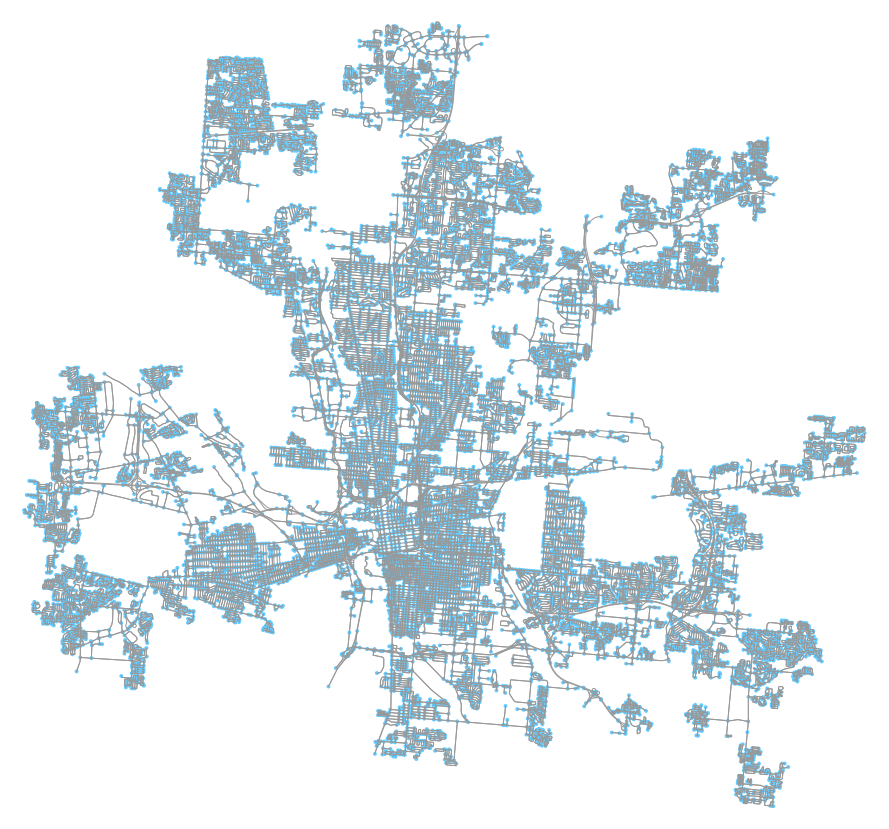

In [164]:
fig, ax = ox.plot_graph(G, fig_height=15, show=False, close=False)
ax.scatter(pxm_have_location['long_combined'], pxm_have_location['lat_combined'], alpha=0.5, c='red')

In [165]:
bbox = ox.core.bbox_from_point((39.977110, -83.003500), 1000)

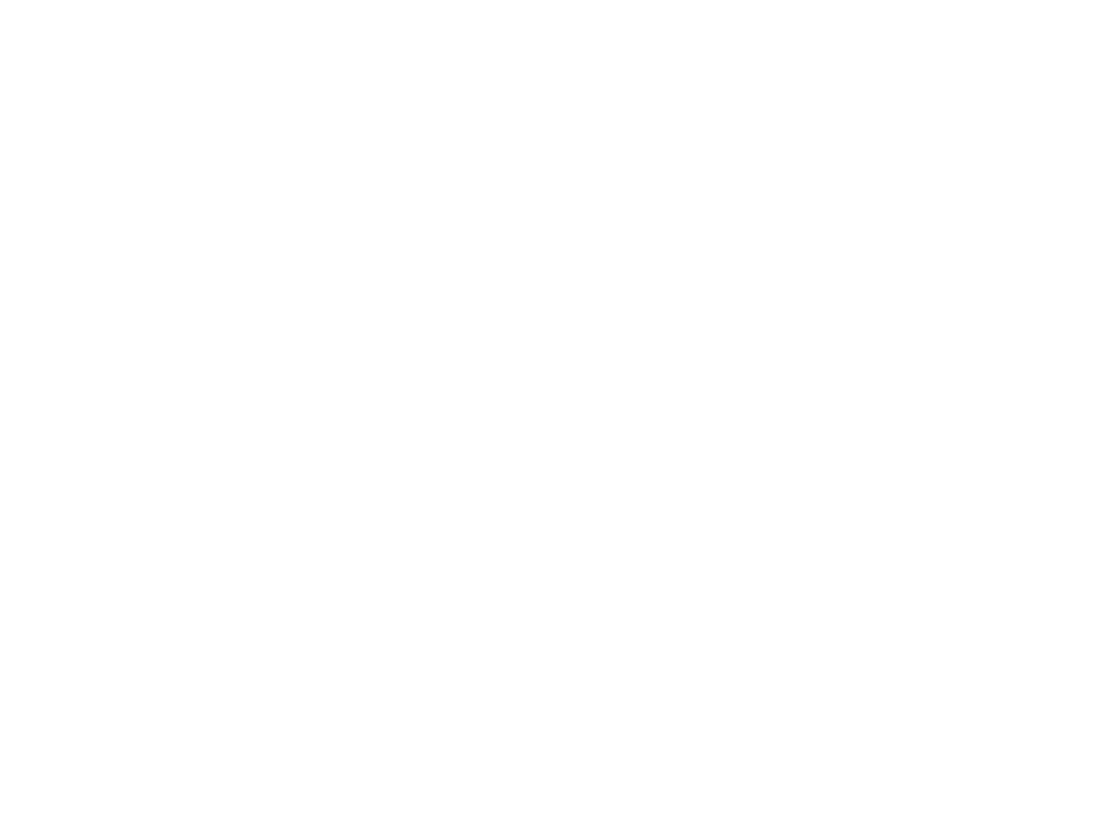

In [120]:
fig, ax = ox.plot_graph(G, bbox, fig_height=15, show=False, close=False)
ax.scatter(pxm_have_location['long_combined'], pxm_have_location['lat_combined'], alpha=0.5, c='red')

In [35]:
# import networkx as nx
# import geopandas as gpd

# G = ox.project_graph(G)
# ints = ox.clean_intersections(G)

# gdf = gpd.GeoDataFrame(ints, columns=['geometry'], crs=G.graph['crs'])
# X = gdf['geometry'].map(lambda pt: pt.coords[0][0])
# Y = gdf['geometry'].map(lambda pt: pt.coords[0][1])

# nodes = ox.get_nearest_nodes(G, X, Y, method='kdtree')
# connections = {}

# for n in nodes:
#     connections[n] = set([])
#     for nbr in nx.neighbors(G, n):
#         for d in G.get_edge_data(n, nbr).values():
#             if 'name' in d:
#                 if type(d['name']) == str:
#                     connections[n].add(d['name'])
#                 elif type(d['name']) == list:
#                     for name in d['name']:
#                         connections[n].add(name)
#                 else:
#                     connections[n].add(None)
#             else:
#                 connections[n].add(None)
                
# print(connections)
# {230195025: {'Canal Bridge Drive', 'Crescent Boat Lane'}, 229849671: {'Empire Mills Run', 'Abraham Drive', 'Crescent Boat Lane'}, 229849692: {'Empire Mills Run', 'Canal Bridge Drive'}, 6645817420: {'Bersal Lane', 'Kahr Drive'}, 6645817409: {'Bersal Lane', 'Armalite Place', 'Kahr Drive'}, 229757859: {'Abraham Drive', 'Winchester Lakes Boulevard', 'Crescent Boat Lane'}, 229947577: {'Winchester Pike', 'Gender Road'}, 229827034: {'Winshire Drive', 'Winchester Lakes Boulevard'},